(0.05, 'nanoseconds per adc')
0.000800000056624


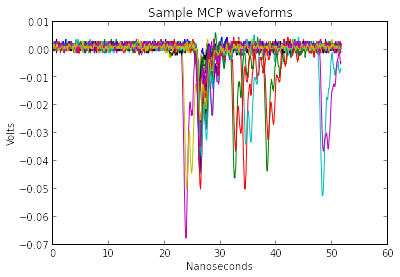

In [27]:
'''
This console is setup to look at mcp data split across two channels.
Each channel should have its own wfm file as output by the oscilliscope
with the target of measuring the timing resolution on the mcp. The expected
experimental setup is to mask off the MCP such that only a pinhole is
visible on the photocathode. An LED will then send pulses of light into
the pinhole with low intensity, and the oscilliscope will record waveforms
that are the coincidence trigger between the LED and the MCP.
'''

''' USER INPUT '''
file_name_ch1 = '800_b6_pre_7-23-2015106_Ch1.wfm'
file_name_ch2 = '800_b6_pre_7-23-2015106_Ch2.wfm'
''' ---------- '''
%matplotlib inline
from wfmread import wfmread
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

'''
Load in data files (wfm) and take a peak
'''
ch1 = wfmread(file_name_ch1)
ch2 = wfmread(file_name_ch2)


binsize=1
tunit = ch1.time_scale*1e9
x = np.arange(0, tunit*ch1.record_length, tunit)
for i in range(10):
    plt.plot(x, ch1.wflist[i])
    plt.plot(x, ch2.wflist[i])
    
print(ch1.time_scale*1e9, 'nanoseconds per adc')

print(ch1.dimscale)
plt.title('Sample MCP waveforms')
plt.ylabel('Volts')
plt.xlabel('Nanoseconds')
plt.show()

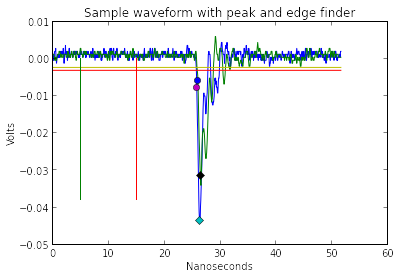

In [28]:
''' Based on the output from above choose the pedestal region '''
# Pedestal in units given by the above plot
ped_min = 5
ped_max = 15
''' --------------------------------------------------------- '''

pedestal_range = slice( np.where(x>=ped_min)[0][0],
                        np.where(x>ped_max)[0][0] )

''' 
The following function finds the first peak in case there
are multiples in a waveform. Furthermore it returns an "edge" 
which we will define here as 20% of the peak height from the
pedestal on the leading edge of the pulse.
'''
def first_peak(waveform):
    pedestal = np.mean(waveform[pedestal_range])
    # Iterate through the voltages looking for the first peak (v>6 sig)
    deviation = np.std(waveform[pedestal_range])
    condition = pedestal - 6*deviation
    window, step = 100, 20
    endpoint = len(waveform)-1
    found_peak = False
    for i in range(pedestal_range.stop, len(waveform), step):
        look = waveform[i:min(i+window,endpoint)].min()
        if look < condition:
            peakAt = np.argwhere(waveform==look)[0][0]
            found_peak = True
            break
    if not found_peak:
        return -1, (-1,-1), -1, -1
    # This will likely find the leading edge, now refine
    #peakAt = waveform[int(peakAt-window/2):int(peakAt+window/2)].argmin()+int(peakAt-window/2)
    # Look around the the supposed peak, but don't look past the boundaries
    lookleft = max(int(peakAt-window/2),0)
    lookright = min(int(peakAt+window/2), len(waveform)-1)
    try:
        peakAt = waveform[lookleft:lookright].argmin()+lookleft 
    except ValueError:
        print(peakAt)
        print(int(peakAt-window/2))
        print(waveform[int(peakAt-window/2):int(peakAt+window/2)])
        return
    peak = waveform[peakAt]
    # Starting at peakAt go left until peak-ped, linear extrapolation
    v_edge = (pedestal - (pedestal-peak)*0.20)
    for idx, v in reversed(list(enumerate(waveform[0:peakAt]))):
        if v > v_edge: #crossed the point
            m = waveform[idx+1]-waveform[idx]
            b = waveform[idx]-m*idx
            g = lambda y: (y-b)/m
            edge = (g(v_edge), v_edge)
            break
    
    return peakAt, edge, pedestal, deviation

'''Show the peak finder in action'''


#x = np.arange(0,binsize*len(ch1.wflist[1]),binsize)
''' Pick an event to peak at '''
ev = 7
plt.plot(x, ch1.wflist[ev])
plt.plot(x, ch2.wflist[ev])
# Pedestal line, peak, and window
peak, edge, ped, dev = first_peak(ch1.wflist[ev])
plt.plot(x, np.zeros(len(x))+ped-6*dev) # Pedestal Line
#plt.plot((peak, peak),(0, -0.06))
plt.plot(peak*tunit, ch1.wflist[ev][peak], 'D')
plt.plot(edge[0]*tunit,edge[1],'o')

peak, edge, ped, dev = first_peak(ch2.wflist[ev])
plt.plot(x, np.zeros(len(x))+ped-6*dev) # Pedestal Line
#plt.plot((peak, peak),(0, -0.06))
plt.plot(peak*tunit, ch2.wflist[1][peak], 'D')
plt.plot(edge[0]*tunit,edge[1],'o')

# Pedstal range lines
height = min(ch1.wflist[ev][peak], ch1.wflist[ev][peak])
plt.plot((pedestal_range.start*tunit, pedestal_range.start*tunit),
         (0, height))
plt.plot((pedestal_range.stop*tunit, pedestal_range.stop*tunit),
         (0, height))

plt.title('Sample waveform with peak and edge finder')
plt.ylabel('Volts')
plt.xlabel('Nanoseconds')

plt.show()

Standard deviation of 0.030 nanoseconds
Mean value of -0.173 nanoseconds


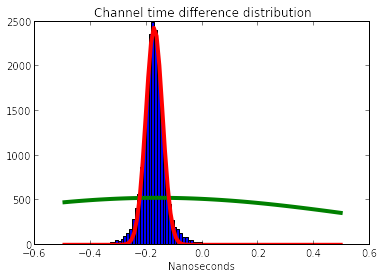

In [30]:
''' 
Once we have peaks and edges of waveforms we can determine the
arrival time by looking at the difference in time of these "edges"
'''

def delta_t(wf1, wf2):
    peak1, edge1, ped1, dev1 = first_peak(wf1)
    peak2, edge2, ped2, dev2 = first_peak(wf2)
    if (peak1 != -1) and (peak2 != -1):
        dt = edge1[0] - edge2[0]
    else:
        dt = False
    
    return dt

dt = []
for one, two in zip(ch1.wflist, ch2.wflist):
    ddtt = delta_t(one,two)
    if ddtt:
        dt.append(ddtt)
dt = np.array(dt)
dt *= tunit
''' Histogram the results of the time differences '''
n, bins, patches = plt.hist(dt, bins=100, range=(-0.5,0.5),log=False)

true_bins = ((np.roll(bins,1)+bins)/2.0)[1:]
#plt.plot(true_bins,n)

''' Fit this distribution with a Gaussian '''
def fit_func(x,norm,sigma,mu):
    return norm*(2*sigma**2*np.pi)**(-0.5)*np.exp(-(x-mu)**2/(2*sigma**2))

#bin_size = (true_bins[-1]-true_bins[0])/len(true_bins)
''' Start by estimating the parameters of the gaussian with the data '''
integral = np.sum(n)*tunit
mean = np.mean(dt)
sig = np.std(dt)

p0 = [integral, sig, mean]

plt.plot(true_bins, fit_func(true_bins, p0[0], p0[1], p0[2]), linewidth=4)

popt, pcov = curve_fit(fit_func, true_bins, n, p0)
plt.plot(true_bins, fit_func(true_bins, popt[0], popt[1], popt[2]), linewidth=4)

norm, sig, mean = popt

print('Standard deviation of %0.3f nanoseconds' % popt[1])
print('Mean value of %0.3f nanoseconds' % popt[2])

plt.title('Channel time difference distribution')
plt.xlabel('Nanoseconds')

plt.show()

In [38]:
''' Calculate the signal speed '''
''' Step 1: Measure the distances between the pinhole and the channel sma connections '''
ch1_distance = 15
ch2_distance = 45

# millimeters
delta_x = np.abs(ch2_distance - ch1_distance)
# nanoseconds
delta_t = np.abs(mean)
# speed of light (mm / ns)
sol = 300

dxdt = delta_x / delta_t / sol

print("Signal speed of %0.2f c" % dxdt)
print("Signal travels at %0.3f of the speed of light" % (dxdt*100))

Signal speed of 0.58 c
Signal travels at 57.653 of the speed of light
